## Potential Talents - Part 3

----

### Objectives:

Retrieve the most similar job titles to a query using several embedding families, and compare their rankings.

### Summary:

   0) Setup & Data
   1) Load custom SGNS embeddings (from Part 2, mini-Word2Vec)
   2) Tokenization for titles (keep it simple & consistent)
   3) Custom mini-Word2Vec (my SGNS from part 2)
   4) Word2Vec (Google)
   5) GloVe (Stanford)
   6) FastText (Meta)
   7) BERT (Google; mean/CLS pooling)
   8) Sentece-BERT (SBERT; sentence-level embeddings)
   9) Ranking & side-by-side comparison (qualitative / quantitative)
  

----


## 0. Setup & Data

In [1]:
import os, math, random
import numpy as np
import pandas as pd
import torch
from torch import nn

In [2]:
SEED = 23
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [3]:
df = pd.read_csv("./data/potential_talents.csv")
titles = df["job_title"].astype(str).tolist()
len(titles), titles[:5]


(104,
 ['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional',
  'Native English Teacher at EPIK (English Program in Korea)',
  'Aspiring Human Resources Professional',
  'People Development Coordinator at Ryan',
  'Advisory Board Member at Celal Bayar University'])

## 1. Load custom SGNS embeddings (from Part 2, mini-Word2Vec)

In [4]:
# Load SGNS checkpoint (from Part 2)
ckpt_path = "checkpoints/sgns_text8.pt"
ckpt = torch.load(ckpt_path, map_location="cpu")


In [5]:
ckpt.keys()

dict_keys(['model_state', 'itos', 'config'])

In [6]:
ckpt['config'] 

{'embed_dim': 300}

In [7]:
ckpt['itos'][:10] 

['a', 'aa', 'aaa', 'aaaa', 'aaai', 'aaas', 'aac', 'aachen', 'aafc', 'aage']

In [8]:
print(type(ckpt['model_state']))
print(ckpt['model_state'].keys())

<class 'collections.OrderedDict'>
odict_keys(['emb_in.weight', 'emb_out.weight'])


In [9]:
itos = ckpt["itos"]
stoi = {w:i for i,w in enumerate(itos)}

E_in  = ckpt["model_state"]["emb_in.weight"].detach().float()   # [|V|, D]
E_out = ckpt["model_state"]["emb_out.weight"].detach().float()  # [|V|, D]

# as in Part2, use the avg 
E_comb = 0.5 * (E_in + E_out)
E_comb = E_comb / (E_comb.norm(dim=1, keepdim=True) + 1e-12)

E_comb.shape


torch.Size([71290, 300])

## 2) Tokenization for titles (keep it simple & consistent)

In [10]:
import re, unicodedata
import nltk
_ = nltk.download('punkt', quiet=True)

In [11]:
# regex for separator chars to normalize/split title delimiters
SEP_RE = re.compile(r"[|/\\•·–—\-]+")      

def canonicalize_title(s: str, strip_org_tail: bool = True) -> str:
    """
    Light canonicalization (cleaning) that preserves full sentence content:
    - Unicode NFKC normalization, trim, lowercase
    - Normalize separators (& -> 'and')
    - Collapse whitespace
    Input: string → Output: cleaned string.
    """
    
    # if the input isn’t a string, return an empty string
    if not isinstance(s, str): 
        return ""
    
    # Unicode normalization form NFKC + strip + lowercase
    s = unicodedata.normalize("NFKC", s).strip().lower()
    s = SEP_RE.sub(" ", s)                 # “hr manager | engie” -> “hr manager  engie”
    s = s.replace("&", " and ")
        
    # collapses any run of whitespace (spaces, tabs) to a single space
    s = re.sub(r"\s+", " ", s)
    
    return s

In [12]:
# Simple, stable regex tokenizer: keep a–z sequences (no stopword/org stripping)
TOKEN_RE = re.compile(r"[a-z]+")

def tokenize_title(s: str, drop_org_like=True) -> list[str]:
    """
    Canonicalize, then regex-tokenize. No stopword/org filtering.
    Input: string → Output: list of tokens.
    """ 
    s = canonicalize_title(s)
    # every sequence of [a-z]+ becomes one token
    toks = TOKEN_RE.findall(s)
    
    return toks

In [13]:
# Build shared columns (used by ALL embedding families)
df["title_text"] = df["job_title"].apply(canonicalize_title)   # full sentence, orgs kept
df["tokens"]     = df["title_text"].apply(tokenize_title)      # tokens, same for every embedding family

# Peek
df[["job_title", "title_text", "tokens"]].head(10)


,job_title,title_text,tokens
0,2019 C.T. Bauer College of Business Graduate (...,2019 c.t. bauer college of business graduate (...,"[c, t, bauer, college, of, business, graduate,..."
1,Native English Teacher at EPIK (English Progra...,native english teacher at epik (english progra...,"[native, english, teacher, at, epik, english, ..."
2,Aspiring Human Resources Professional,aspiring human resources professional,"[aspiring, human, resources, professional]"
3,People Development Coordinator at Ryan,people development coordinator at ryan,"[people, development, coordinator, at, ryan]"
4,Advisory Board Member at Celal Bayar University,advisory board member at celal bayar university,"[advisory, board, member, at, celal, bayar, un..."
5,Aspiring Human Resources Specialist,aspiring human resources specialist,"[aspiring, human, resources, specialist]"
6,Student at Humber College and Aspiring Human R...,student at humber college and aspiring human r...,"[student, at, humber, college, and, aspiring, ..."
7,HR Senior Specialist,hr senior specialist,"[hr, senior, specialist]"
8,Student at Humber College and Aspiring Human R...,student at humber college and aspiring human r...,"[student, at, humber, college, and, aspiring, ..."
9,Seeking Human Resources HRIS and Generalist Po...,seeking human resources hris and generalist po...,"[seeking, human, resources, hris, and, general..."


## 3) Custom mini-Word2Vec: 

### 3.1) Encode a title as the mean of its word vectors

In [14]:
E = E_comb

@torch.no_grad()
def encode_tokens_mean(tokens: list[str], E: torch.Tensor, stoi: dict) -> torch.Tensor | None:
    idxs = [stoi[t] for t in tokens if t in stoi]
    if not idxs:
        return None
    v = E[idxs].mean(dim=0)                 # [D]
    return v / (v.norm() + 1e-12)

@torch.no_grad()
def encode_title_mean(text: str, E: torch.Tensor, stoi: dict) -> torch.Tensor | None:
    return encode_tokens_mean(tokenize_title(text), E, stoi)

In [15]:
# Rebuild title matrix using df["tokens"] (shared preprocessing)
vecs, keep_idx = [], []
for i, toks in enumerate(df["tokens"]):
    v = encode_tokens_mean(toks, E, stoi)
    if v is not None:
        vecs.append(v); keep_idx.append(i)

X_sgns_mean = torch.stack(vecs)  # [N_kept, D], rows are L2-normalized
print("encoded titles:", X_sgns_mean.shape, "kept rows:", len(keep_idx), "of", len(df))


encoded titles: torch.Size([104, 300]) kept rows: 104 of 104


In [16]:
X_sgns_mean[0] 

tensor([ 0.0102, -0.0397,  0.0605, -0.0698, -0.0451, -0.0469,  0.0385, -0.0740,
         0.0400, -0.0557, -0.0359,  0.0659,  0.0657, -0.0421, -0.0308,  0.0900,
         0.0729,  0.0266,  0.0625, -0.0746,  0.0684, -0.0777, -0.0475, -0.0569,
        -0.0385, -0.0662,  0.0363, -0.0352,  0.0336, -0.0520, -0.0362, -0.0415,
        -0.0313, -0.0825,  0.0237, -0.0868,  0.0350, -0.0584, -0.0503, -0.0151,
        -0.0609,  0.0724, -0.0663, -0.0268,  0.0566, -0.0289, -0.0805,  0.0526,
         0.0408, -0.0282,  0.0904,  0.0533, -0.0580, -0.0389,  0.0214,  0.0406,
         0.0169, -0.0786,  0.0762,  0.0449,  0.0346,  0.0671, -0.1035,  0.0652,
         0.0573, -0.0475, -0.0698,  0.0104,  0.0614, -0.0513,  0.0431, -0.0888,
        -0.0016,  0.0719,  0.0592,  0.0448,  0.0400,  0.0439,  0.0604, -0.0345,
         0.0523, -0.0517, -0.0570, -0.0236,  0.0325, -0.0366, -0.0302, -0.0621,
        -0.0702, -0.0622, -0.0323, -0.0287,  0.0569,  0.0271,  0.0420,  0.0780,
        -0.0658,  0.0758,  0.0521,  0.04

In [17]:
import matplotlib.pyplot as plt

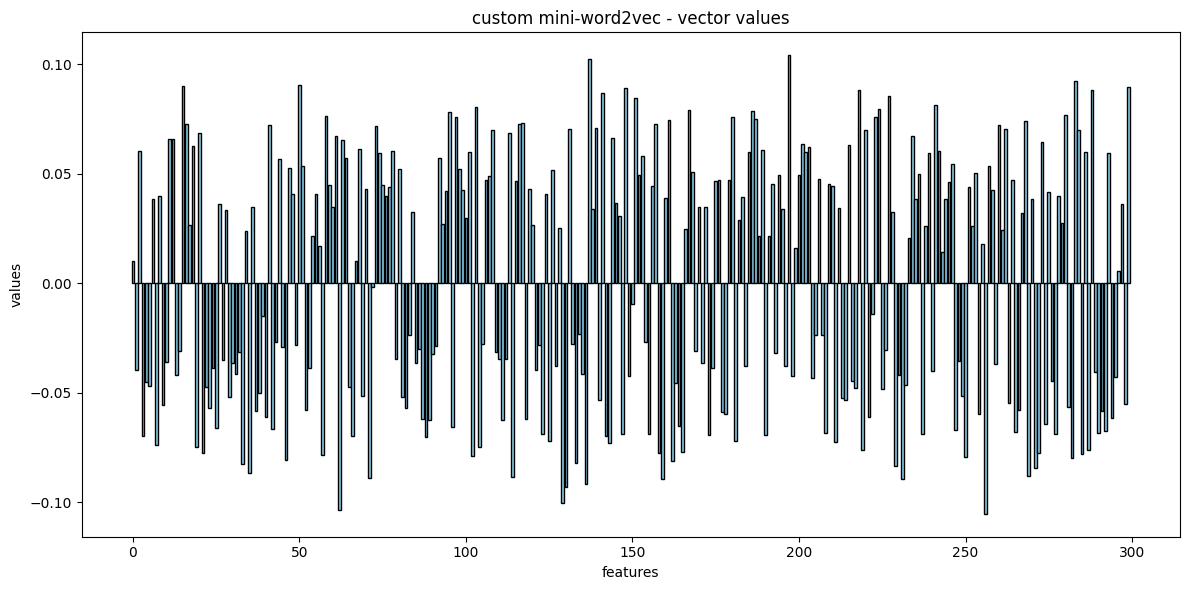

In [18]:
plt.figure(figsize=(12, 6))
plt.bar(range(300), X_sgns_mean[0], color='skyblue', edgecolor='black')
plt.title("custom mini-word2vec - vector values")
plt.xlabel("features")
plt.ylabel("values")
plt.tight_layout()
plt.show()

### 3.2) Cosine search over titles (dot product of normalized vectors)

Cosine search over titles: one function we can reuse for SGNS(mini-Word2Vec)/GloVe/FastText by swapping E, stoi, X, keep_idx.

In [19]:
# search using cosine similarity
@torch.no_grad()
def search_titles(query: str,
                  X: torch.Tensor,
                  E: torch.Tensor,
                  stoi: dict,
                  keep_idx: list[int],
                  df: pd.DataFrame,
                  topk: int = 10,
                  dedupe: bool = True):
    
    # encode query with the SAME tokenizer
    q_tokens = tokenize_title(query)
    q = encode_tokens_mean(q_tokens, E, stoi)
    if q is None:
        return [], "Query has no in-vocab tokens."

    sims = (X @ q)                                      # cosine = dot (rows normalized)
    top = torch.topk(sims, k=min(topk*3, sims.numel())) # oversample if deduping

    rows = []
    seen = set()
    for idx in top.indices.tolist():
        row_id = keep_idx[idx]
        title_str = df.loc[row_id, "job_title"]            # <-- key used for dedupe
        if dedupe:
            if title_str in seen:                          # <-- duplicates dropped
                continue
            seen.add(title_str)
        rows.append((title_str, float(sims[idx].item())))
        if len(rows) == topk:
            break
    return rows, None




In [20]:
# quick test
for q in ["data scientist", "machine learning engineer", "backend developer", "product manager"]:
    res, err = search_titles(q, X_sgns_mean, E, stoi, keep_idx, df, topk=10, dedupe=True)
    print(f"\nQuery: {q}")
    if err: print("  ", err)
    else:
        for t, s in res:
            print(f"  {s: .3f}  {t}")



Query: data scientist
   0.793  Information Systems Specialist and Programmer with a love for data and organization.
   0.748  Junior MES Engineer| Information Systems
   0.731  SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR
   0.729  Human Resources professional for the world leader in GIS software
   0.727  Business Intelligence and Analytics at Travelers
   0.714  Aspiring Human Resources Manager | Graduating May 2020 | Seeking an Entry-Level Human Resources Position in St. Louis
   0.706  Undergraduate Research Assistant at Styczynski Lab
   0.706  Student at Indiana University Kokomo - Business Management - 
Retail Manager at Delphi Hardware and Paint
   0.702  2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional
   0.701  Business Management Major and Aspiring Human Resources Manager

Query: machine learning engineer
   0.825  Junior MES Engineer| Information Systems


## 4) Experiment with the GoogleNews Word2Vec vectors

A) Using Gensim’s downloader (auto-download, ~1.6GB):

In [21]:
from gensim.models import KeyedVectors


In [22]:
W2V_PATH = r"./data/GoogleNews-vectors-negative300.bin"

In [ ]:
# Load the binary GoogleNews KeyedVectors
w2v = KeyedVectors.load_word2vec_format(W2V_PATH, binary=True)
print("w2v vocab:", len(w2v), "dim:", w2v.vector_size)

w2v vocab: 3000000 dim: 300


: 